<h1>Imports</h1>

In [1]:
import tensorflow as tf
TF_FORCE_GPU_ALLOW_GROWTH= True
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Using the CPU instead.")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import gc
import seaborn as sns
import json


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

from keras.layers import Input
from tensorflow.keras.layers import Dense , Dropout, BatchNormalization , Flatten, Dropout, Dense, Flatten, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2, ResNet50V2
from keras.optimizers import Adam

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping



from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ModelModifier
from tf_keras_vis.utils.scores import CategoricalScore



from tf_keras_vis.utils.model_modifiers import ReplaceToLinear





2024-04-18 09:57:59.866950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 09:57:59.866991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 09:57:59.918968: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 09:58:00.034786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 09:58:00.770926: W tensorflow/compiler/tf2

<h1> Load Dataset </h1>

Number of training images:  5712
Number of testing images:  1311
Label counts in training data:  Counter({'notumor': 1595, 'pituitary': 1457, 'meningioma': 1339, 'glioma': 1321})
Label counts in testing data:  Counter({'notumor': 405, 'meningioma': 306, 'pituitary': 300, 'glioma': 300})


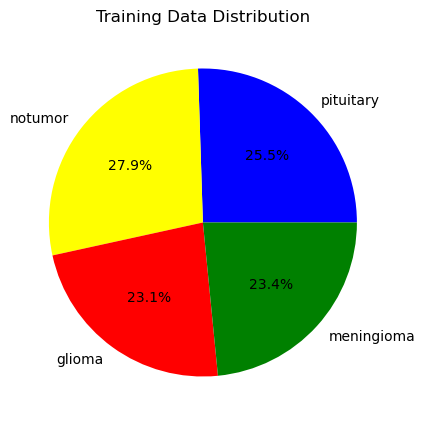

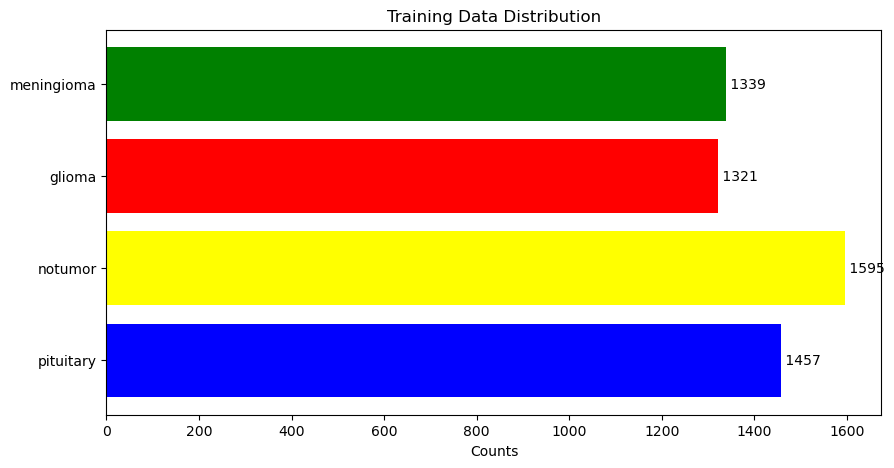

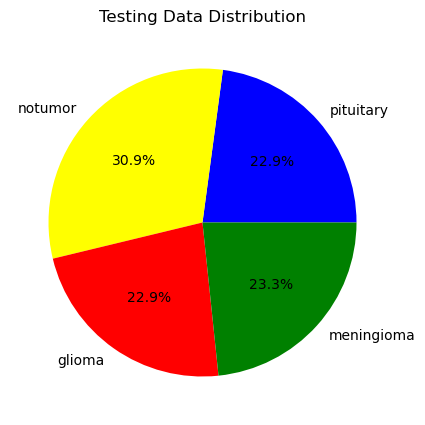

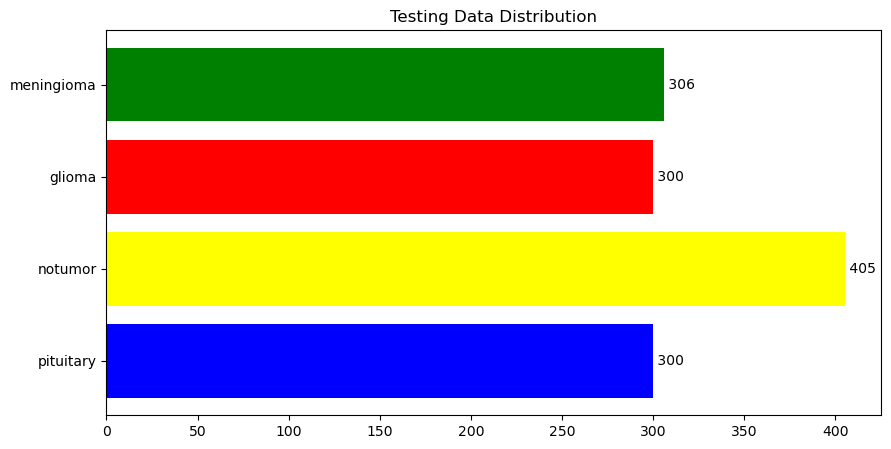

Found 1311 validated image filenames belonging to 4 classes.


In [2]:

trainining_data_path = 'brain_images/Training/' # Path to folder containing training image data
testing_data = 'brain_images/Testing/' # Path to folder containing testing image data

tf.random.set_seed(123)
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 16 
workers = 4

image_paths_training = []
labels = []

train_models = True
load_weights = False

for class_folder in os.listdir(trainining_data_path):
    class_folder_path = os.path.join(trainining_data_path, class_folder)
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_paths_training.append(os.path.join(class_folder_path, image_file))
                labels.append(class_folder)

image_paths_testing = []
testing_labels = []

for class_folder in os.listdir(testing_data):
    class_folder_path = os.path.join(testing_data, class_folder)
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_paths_testing.append(os.path.join(class_folder_path, image_file))
                testing_labels.append(class_folder)

print("Number of training images: ", len(image_paths_training))
print("Number of testing images: ", len(image_paths_testing))

label_counts_training = Counter(labels)
print("Label counts in training data: ", label_counts_training)

label_counts_testing = Counter(testing_labels)
print("Label counts in testing data: ", label_counts_testing)

training_labels_graphs, trianing_labels_counts = zip(*label_counts_training.items())

colors = ['blue', 'yellow', 'red', 'green']


plt.figure(figsize=(10, 5))
plt.pie(trianing_labels_counts, labels=training_labels_graphs, autopct='%1.1f%%', colors=colors)
plt.title('Training Data Distribution')
plt.show()

plt.figure(figsize=(10, 5))
bars = plt.barh(training_labels_graphs, trianing_labels_counts, color=colors)

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f' {width}', va='center')

plt.title('Training Data Distribution')
plt.xlabel('Counts')
plt.show()


testing_labels_graphs, testing_labels_counts = zip(*label_counts_testing.items())

plt.figure(figsize=(10, 5))
plt.pie(testing_labels_counts, labels=testing_labels_graphs, autopct='%1.1f%%', colors=colors)
plt.title('Testing Data Distribution')
plt.show()

plt.figure(figsize=(10, 5))
bars = plt.barh(testing_labels_graphs, testing_labels_counts, color=colors)

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f' {width}', va='center')

plt.title('Testing Data Distribution')
plt.show()


os.makedirs('Graphs', exist_ok=True)
os.makedirs('Graphs/InceptionResNetV2', exist_ok=True)
os.makedirs('Graphs/InceptionV3', exist_ok=True)
os.makedirs('Graphs/ResNet50V2', exist_ok=True)

test_df = pd.DataFrame({'path': image_paths_testing, 'label': testing_labels})
test_datagen = IDG(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=False, color_mode='rgb', batch_size=BATCH_SIZE, workers=workers, seed=123)


<h1> Visualising Dataset</h1>

In [ ]:
from PIL import Image
from collections import defaultdict

def load_images(image_paths, target_size):
    return np.array([np.array(Image.open(path).convert('RGB').resize(target_size)) for path in image_paths])

def plotImages(images, labels):
    plt.figure(figsize=[15,11])                 
    
    images_by_class = defaultdict(list)
    for image, label in zip(images, labels):
        images_by_class[label].append(image)
    
    selected_images = [image for images in images_by_class.values() for image in images[:5]]
    selected_labels = [label for label, images in images_by_class.items() for image in images[:5]]
    
    for i in range(len(selected_images)):
        plt.subplot(len(images_by_class), 5, i+1)  
        plt.imshow(selected_images[i])             
        plt.title(selected_labels[i])              
        plt.axis("off")
    plt.show()

images = load_images(image_paths_training, IMAGE_SIZE)

plotImages(images, labels)

del images

<h1> Models </h1>

<h3> InceptionResNetV2 </h3>

In [ ]:
def create_model():
    dropout_rate = 0.5 

    

    input_tensor = Input(shape=IMAGE_SIZE + (3,))
    InceptionResNetV2_model = InceptionResNetV2(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False, input_tensor=input_tensor)

    out_relu = InceptionResNetV2_model.layers[-1]
    x = Flatten()(out_relu.output)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(4, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    
    return model

<h3> InceptionV3 <h3>

In [ ]:
def InceptionV3_create_model():
    dropout_rate = 0.5 

    input_tensor = Input(shape=IMAGE_SIZE + (3,))
    InceptionV3_model = InceptionV3(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False, input_tensor=input_tensor)

    out_relu = InceptionV3_model.layers[-1]
    x = Flatten()(out_relu.output)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    
    return model

<h3> ResNet50V2 </h3> 

In [ ]:
def ResNet50V2_create_model():
    dropout_rate = 0.5 

    input_tensor = Input(shape=IMAGE_SIZE + (3,))
    ResNet50V2_model = ResNet50V2(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False, input_tensor=input_tensor)

    out_relu = ResNet50V2_model.layers[-1]
    x = Flatten()(out_relu.output)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    
    return model

<h1> Model Structure

In [ ]:
import matplotlib.image as mpimg

InceptionResNetV2_model = create_model()
InceptionV3_model = InceptionV3_create_model()
ResNet50V2_model = ResNet50V2_create_model()

plot_model(InceptionResNetV2_model, to_file='Graphs/InceptionResNetV2/InceptionResNetV2_model.png', show_shapes=True, show_layer_names=True)
plot_model(InceptionV3_model, to_file='Graphs/InceptionV3/InceptionV3_model.png', show_shapes=True, show_layer_names=True)
plot_model(ResNet50V2_model, to_file='Graphs/ResNet50V2/ResNet50V2_model.png', show_shapes=True, show_layer_names=True)


fig, axs = plt.subplots(1, 3, figsize=(50, 40))


img1 = mpimg.imread('Graphs/InceptionResNetV2/InceptionResNetV2_model.png')
img3 = mpimg.imread('Graphs/InceptionV3/InceptionV3_model.png')
img4 = mpimg.imread('Graphs/ResNet50V2/ResNet50V2_model.png')


axs[0].imshow(img1)
axs[0].axis('off')
axs[0].set_title('InceptionResNetV2')
axs[0].set_anchor('N')

axs[2].imshow(img4)
axs[2].axis('off')
axs[2].set_title('ResNet50V2')
axs[2].set_anchor('N')

axs[1].imshow(img3)
axs[1].axis('off')
axs[1].set_title('InceptionV3')
axs[1].set_anchor('N')



plt.savefig('Graphs/Models_Structure.pdf', format='pdf')

del InceptionResNetV2_model, InceptionV3_model, ResNet50V2_model , img1, img3, img4

gc.collect()


<h1>K-cross validation</h1>

In [ ]:
from keras import backend as K
from tensorflow.keras import mixed_precision
import shutil

mixed_precision.set_global_policy('mixed_float16')

number_of_epochs = 15

models_and_scores = []
#class_names = []

count = 1

skf = StratifiedKFold(n_splits=4 ,shuffle=True, random_state=123)

for train_index, val_index in skf.split(image_paths_training, labels):
    train_paths, val_paths = np.array(image_paths_training)[train_index], np.array(image_paths_training)[val_index]
    train_labels, val_labels = np.array(labels)[train_index], np.array(labels)[val_index]
        
        
    train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
    val_df = pd.DataFrame({'path': val_paths, 'label': val_labels})
    

    print("Train class distribution: ", train_df['label'].value_counts())
    print("Val class distribution: ", val_df['label'].value_counts())
        
    train_datagen = IDG(horizontal_flip=True, vertical_flip=True, cval=0, fill_mode='nearest', zoom_range=0.1, rotation_range=30, rescale=1./255, shear_range=0.2, width_shift_range=0.2, height_shift_range=0.2)
        

    val_datagen = IDG(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(train_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size=BATCH_SIZE, workers=workers, seed=123)
    val_generator = val_datagen.flow_from_dataframe(val_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size=BATCH_SIZE, workers=workers, seed=123)

    del train_df, val_df, train_paths, val_paths, train_labels, val_labels
        
    model = create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    print("====================================================================================================", flush=True)
    print("====================================================================================================", flush=True)
    print("========================================InceptionResNetV2 starting===================================", flush=True)
    print("====================================================================================================", flush=True)
    print(f"==============================================   {count}   ==============================================", flush=True)
    history = model.fit_generator(train_generator, epochs=number_of_epochs, validation_data=val_generator,  verbose = 1, callbacks=[early_stopping])
    loss, score = model.evaluate(test_generator)

    model_path = f'models/InceptionResNetV2/K-cross-models/InceptionResNetV2_model_{count}.h5'
    model_history_path = f'models/InceptionResNetV2/K-cross-models/InceptionResNetV2_model_{count}.json'

    model.save(model_path)

    print(f"InceptionResNetV2 score: {score}")
    
    count += 1

    with open(model_history_path, 'w') as f:
        json.dump(history.history, f)

    models_and_scores.append((model_path, score, model_history_path))

    del model,  history, score, model_path, loss
    del train_generator, val_generator, train_datagen, val_datagen
    K.clear_session()  
    gc.collect()

best_model, best_score, best_history = max(models_and_scores, key=lambda x: [1])

shutil.move(best_model, 'models/InceptionResNetV2_model.h5')
shutil.move(best_history, 'models/InceptionResNetV2_model.json')

del best_model, models_and_scores, best_score, skf

gc.collect()



<h3> K-cross Validation 2

In [ ]:
gc.collect()

skf2 = StratifiedKFold(n_splits=4 ,shuffle=True, random_state=123)

InceptionV3_models_and_scores = []

count = 1

for train_index, val_index in skf2.split(image_paths_training, labels):
    train_paths, val_paths = np.array(image_paths_training)[train_index], np.array(image_paths_training)[val_index]
    train_labels, val_labels = np.array(labels)[train_index], np.array(labels)[val_index]
        
        
    train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
    val_df = pd.DataFrame({'path': val_paths, 'label': val_labels})

    print("Train class distribution: ", train_df['label'].value_counts())
    print("Val class distribution: ", val_df['label'].value_counts())
        
    train_datagen = IDG(horizontal_flip=True, vertical_flip=True, cval=0, fill_mode='nearest', zoom_range=0.1, rotation_range=30, rescale=1./255, shear_range=0.2, width_shift_range=0.2, height_shift_range=0.2)

    val_datagen = IDG(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(train_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size=BATCH_SIZE, workers=workers, seed=123)
    val_generator = val_datagen.flow_from_dataframe(val_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size=BATCH_SIZE, workers=workers, seed=123)

    del train_df, val_df , train_paths, val_paths, train_labels, val_labels
        
    
    modelInceptionV3 = InceptionV3_create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


    print("====================================================================================================", flush=True)
    print("====================================================================================================", flush=True)
    print("========================================InceptionV3 starting========================================", flush=True)
    print("====================================================================================================", flush=True)
    print(f"=============================================={count}==============================================", flush=True)
    history = modelInceptionV3.fit_generator(train_generator, epochs=number_of_epochs, validation_data=val_generator,  verbose = 1, callbacks=[early_stopping])

    loss , InceptionV3_score = modelInceptionV3.evaluate(test_generator)

    print(f"InceptionV3 score: {InceptionV3_score}")

    modelInceptionV3_path = f'models/InceptionV3/K-cross-models/InceptionV3_model_{count}.h5'
    modelInceptionV3_hisoty_path = f'models/InceptionV3/K-cross-models/InceptionV3_history_model_{count}.json'

    modelInceptionV3.save(modelInceptionV3_path)

    with open(modelInceptionV3_hisoty_path, 'w') as f:
        json.dump(history.history, f)

    
    InceptionV3_models_and_scores.append((modelInceptionV3_path, InceptionV3_score, modelInceptionV3_hisoty_path))
    
    count += 1

    del modelInceptionV3, InceptionV3_score, history, modelInceptionV3_path, loss
    del train_generator, val_generator  
    K.clear_session()  
    gc.collect()


best_InceptionV3_model, best_InceptionV3_score, best_InceptionV3_history = max(InceptionV3_models_and_scores, key=lambda x: x[1])

shutil.move(best_InceptionV3_model, 'models/InceptionV3_model.h5')
shutil.move(best_InceptionV3_history, 'models/InceptionV3_model_history.json')

del best_InceptionV3_model, InceptionV3_models_and_scores, best_InceptionV3_score, skf2
gc.collect()
    

<h3> K-cross validation 3

In [ ]:
gc.collect()

skf3 = StratifiedKFold(n_splits=4 ,shuffle=True, random_state=123)

ResNet50V2_models_and_scores = []

count = 1

for train_index, val_index in skf3.split(image_paths_training, labels):
    train_paths, val_paths = np.array(image_paths_training)[train_index], np.array(image_paths_training)[val_index]
    train_labels, val_labels = np.array(labels)[train_index], np.array(labels)[val_index]
        
        
    train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
    val_df = pd.DataFrame({'path': val_paths, 'label': val_labels})

    print("Train class distribution: ", train_df['label'].value_counts())
    print("Val class distribution: ", val_df['label'].value_counts())
        
    train_datagen = IDG(horizontal_flip=True, vertical_flip=True, cval=0, fill_mode='nearest', zoom_range=0.1, rotation_range=30, rescale=1./255, shear_range=0.2, width_shift_range=0.2, height_shift_range=0.2)
        
    val_datagen = IDG(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(train_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size=BATCH_SIZE, workers=workers, seed=123)
    val_generator = val_datagen.flow_from_dataframe(val_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size=BATCH_SIZE, workers=workers, seed=123)

    del train_df, val_df , train_paths, val_paths, train_labels, val_labels
        
    modelResNet50V2 = ResNet50V2_create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    print("====================================================================================================", flush=True)
    print("====================================================================================================", flush=True)
    print("========================================ResNet50V2 starting=========================================", flush=True)
    print("====================================================================================================", flush=True)
    print(f"=============================================={count}==============================================", flush=True)
    history = modelResNet50V2.fit_generator(train_generator, epochs=number_of_epochs, validation_data=val_generator,  verbose = 1, callbacks=[early_stopping])

    loss, ResNet50V2_score = modelResNet50V2.evaluate(test_generator)

    print(f"ResNEt50V2 score: {ResNet50V2_score}")

    modelResNet50V2_path = f'models/ResNet50V2/K-cross-models/ResNet50V2_model_{count}.h5'
    modelResNet50V2_history_path = f'models/ResNet50V2/K-cross-models/ResNet50V2_history_model_{count}.json'

    modelResNet50V2.save(modelResNet50V2_path)

    with open(modelResNet50V2_history_path, 'w') as f:
        json.dump(history.history, f)


    ResNet50V2_models_and_scores.append((modelResNet50V2_path, ResNet50V2_score, modelResNet50V2_history_path))

    count += 1

    del modelResNet50V2, loss, history, ResNet50V2_score, modelResNet50V2_path 
    del train_generator, val_generator  
    K.clear_session()  
    gc.collect()


best_ResNet50V2_model, best_ResNet50V2_score , best_ResNet50V2_history = max(ResNet50V2_models_and_scores, key=lambda x: [1])

shutil.move(best_ResNet50V2_model, 'models/ResNet50V2_model.h5')
shutil.move(best_ResNet50V2_history, 'models/ResNet50V2_model_history.json')

del best_ResNet50V2_model, ResNet50V2_models_and_scores, best_ResNet50V2_score

gc.collect()


<h1>Scores</h1>

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


2024-04-18 09:58:37.735987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 09:58:38.154565: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 09:58:38.154699: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2024-04-18 09:58:50.603941: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


82/82 [==============================] - 2s 20ms/step


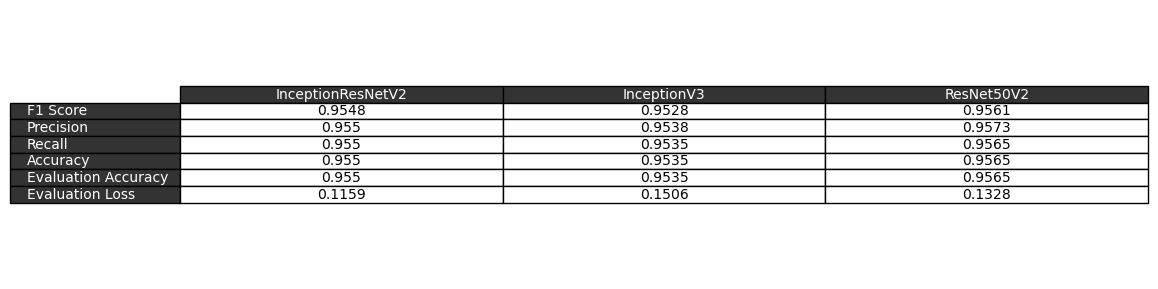

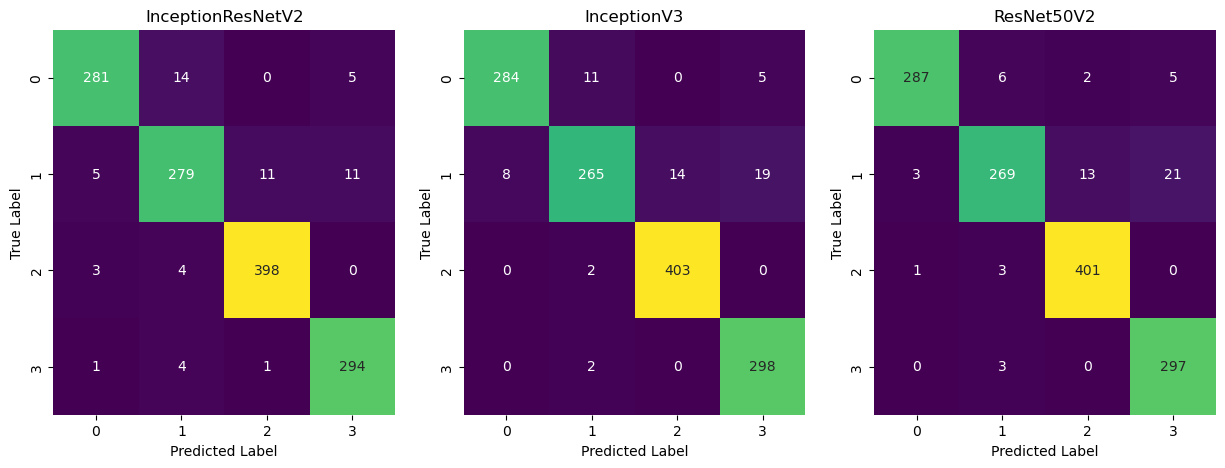

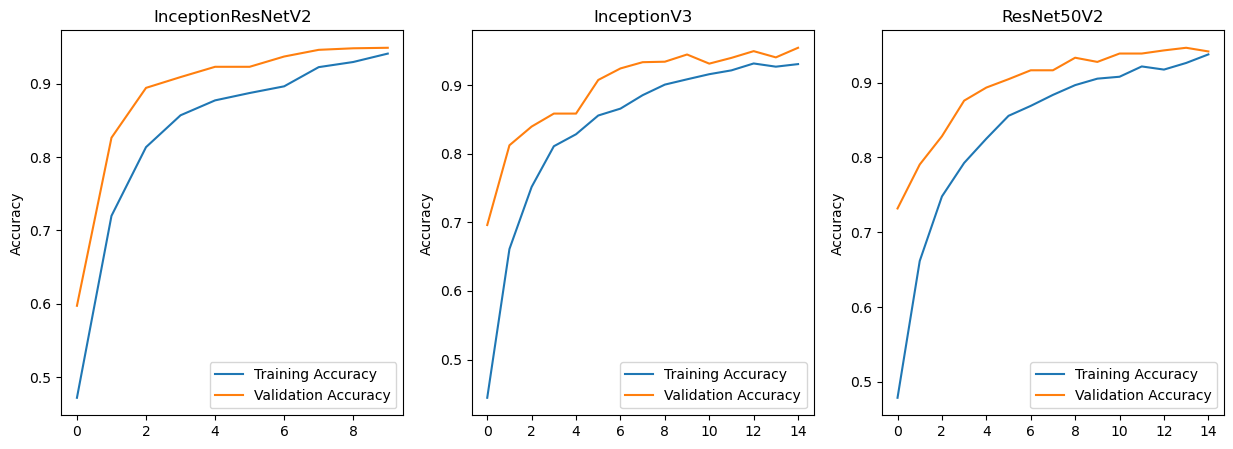

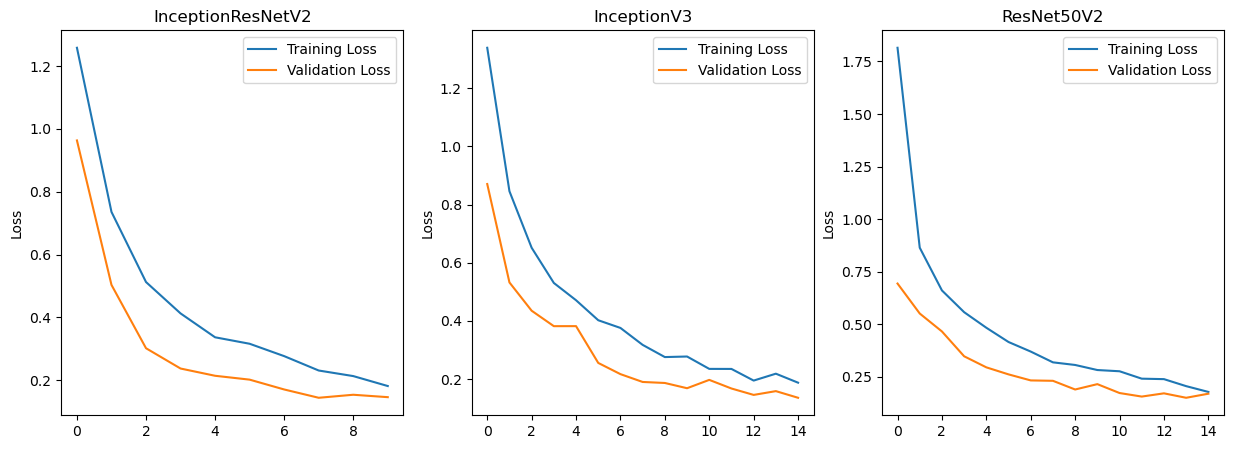

19128

In [3]:
from tensorflow.keras.models import load_model


tf.keras.backend.clear_session()

best_model = load_model('models/InceptionResNetV2_model.h5')
best_InceptionV3_model = load_model('models/InceptionV3_model.h5')
best_ResNet50V2_model = load_model('models/ResNet50V2_model.h5')

#save weights 
best_model.save_weights('weights/InceptionResNetV2_weights.h5')
best_InceptionV3_model.save_weights('weights/InceptionV3_weights.h5')
best_ResNet50V2_model.save_weights('weights/ResNet50V2_weights.h5')


test_generator.shuffle = False
test_generator.reset()

true_labels = test_generator.labels



InceptionResNetV2_predictions_entireset = best_model.predict(test_generator)
InceptionV3_predictions_entireset = best_InceptionV3_model.predict(test_generator)
ResNet50V2_predictions_entireset = best_ResNet50V2_model.predict(test_generator)

InceptionResNetV2_entireset = best_model.evaluate(test_generator, verbose=0)
InceptionV3_evaluations_entireset = best_InceptionV3_model.evaluate(test_generator, verbose=0)
ResNet50V2_evaluations_entireset = best_ResNet50V2_model.evaluate(test_generator, verbose=0)

InceptionResNetV2_predicted_classes = np.argmax(InceptionResNetV2_predictions_entireset, axis=1)
InceptionV3_predicted_classes = np.argmax(InceptionV3_predictions_entireset, axis=1)
ResNet50V2_predicted_classes = np.argmax(ResNet50V2_predictions_entireset, axis=1)


InceptionResNetV2_f1 = f1_score(true_labels, InceptionResNetV2_predicted_classes, average='weighted')
InceptionV3_f1 = f1_score(true_labels, InceptionV3_predicted_classes, average='weighted')
ResNet50V2_f1 = f1_score(true_labels, ResNet50V2_predicted_classes, average='weighted')


InceptionResNetV2_precision = precision_score(true_labels, InceptionResNetV2_predicted_classes, average='weighted')
InceptionV3_precision = precision_score(true_labels, InceptionV3_predicted_classes, average='weighted')
ResNet50V2_precision = precision_score(true_labels, ResNet50V2_predicted_classes, average='weighted')


InceptionResNetV2_recall = recall_score(true_labels, InceptionResNetV2_predicted_classes, average='weighted')
InceptionV3_recall = recall_score(true_labels, InceptionV3_predicted_classes, average='weighted')
ResNet50V2_recall = recall_score(true_labels, ResNet50V2_predicted_classes, average='weighted')


InceptionResNetV2_accuracy = accuracy_score(true_labels, InceptionResNetV2_predicted_classes)
InceptionV3_accuracy = accuracy_score(true_labels, InceptionV3_predicted_classes)
ResNet50V2_accuracy = accuracy_score(true_labels, ResNet50V2_predicted_classes)

df = pd.DataFrame({
    'InceptionResNetV2': [round(InceptionResNetV2_f1, 4), round(InceptionResNetV2_precision, 4), round(InceptionResNetV2_recall, 4), round(InceptionResNetV2_accuracy, 4), round(InceptionResNetV2_entireset[1], 4), round(InceptionResNetV2_entireset[0], 4)],
    'InceptionV3': [round(InceptionV3_f1, 4), round(InceptionV3_precision, 4), round(InceptionV3_recall, 4), round(InceptionV3_accuracy, 4), round(InceptionV3_evaluations_entireset[1], 4), round(InceptionV3_evaluations_entireset[0], 4)],
    'ResNet50V2': [round(ResNet50V2_f1, 4), round(ResNet50V2_precision, 4), round(ResNet50V2_recall, 4), round(ResNet50V2_accuracy, 4), round(ResNet50V2_evaluations_entireset[1], 4), round(ResNet50V2_evaluations_entireset[0], 4)]
}, index=['F1 Score', 'Precision', 'Recall', 'Accuracy', 'Evaluation Accuracy', 'Evaluation Loss'])

fig, ax = plt.subplots(1, 1, figsize=(12.5, 3.5))
table_data = []
color = ['#333333' for _ in range(len(df.index))]
for row in df.index:
    table_data.append(df.loc[row])
table = plt.table(cellText=table_data, colLabels=df.columns, rowLabels=df.index, cellLoc = 'center', loc='center', rowColours=color)

for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_facecolor('#333333')
        cell.get_text().set_color('white')
    elif key[1] == -1:
        cell.get_text().set_color('white')


table.auto_set_font_size(False)
table.set_fontsize(10)
ax.axis('off')

plt.savefig('Graphs/Models_Scores.png', format='png')
plt.show()



confusion_matrix_InceptionResNetV2 = confusion_matrix(true_labels, InceptionResNetV2_predicted_classes)
confusion_matrix_InceptionV3 = confusion_matrix(true_labels, InceptionV3_predicted_classes)
confusion_matrix_ResNet50V2 = confusion_matrix(true_labels, ResNet50V2_predicted_classes)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(confusion_matrix_InceptionResNetV2, cmap='viridis', annot=True, ax=axs[0], cbar=False, fmt='d')
axs[0].set_title('InceptionResNetV2')
axs[0].set(xlabel='Predicted Label', ylabel='True Label')

sns.heatmap(confusion_matrix_InceptionV3, cmap='viridis', annot=True, ax=axs[1], cbar=False, fmt='d')
axs[1].set_title('InceptionV3')
axs[1].set(xlabel='Predicted Label', ylabel='True Label')

sns.heatmap(confusion_matrix_ResNet50V2, cmap='viridis', annot=True, ax=axs[2], cbar=False, fmt='d')
axs[2].set_title('ResNet50V2')
axs[2].set(xlabel='Predicted Label', ylabel='True Label')
plt.savefig('Graphs/Confusion_Matrix.png', format='png')
plt.show()


InceptionResNetV2_model_history = json.load(open('models/InceptionResNetV2_model.json'))
InceptionV3_model_history = json.load(open('models/InceptionV3_model_history.json'))
ResNet50V2_model_history = json.load(open('models/ResNet50V2_model_history.json'))


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.title('Accuracy')

axs[0].plot(InceptionResNetV2_model_history['accuracy'], label='Training Accuracy')
axs[0].plot(InceptionResNetV2_model_history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('InceptionResNetV2')
axs[0].set(ylabel='Accuracy')
axs[0].legend()

axs[1].plot(InceptionV3_model_history['accuracy'], label='Training Accuracy')
axs[1].plot(InceptionV3_model_history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('InceptionV3')
axs[1].set(ylabel='Accuracy')
axs[1].legend()

axs[2].plot(ResNet50V2_model_history['accuracy'], label='Training Accuracy')
axs[2].plot(ResNet50V2_model_history['val_accuracy'], label='Validation Accuracy')
axs[2].set_title('ResNet50V2')
axs[2].set( ylabel='Accuracy')
axs[2].legend()

plt.savefig('Graphs/Accuracy.png', format='png')
plt.show()


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.title('Loss')

axs[0].plot(InceptionResNetV2_model_history['loss'], label='Training Loss')
axs[0].plot(InceptionResNetV2_model_history['val_loss'], label='Validation Loss')
axs[0].set_title('InceptionResNetV2')
axs[0].set(ylabel='Loss')
axs[0].legend()

axs[1].plot(InceptionV3_model_history['loss'], label='Training Loss')
axs[1].plot(InceptionV3_model_history['val_loss'], label='Validation Loss')
axs[1].set_title('InceptionV3')
axs[1].set(ylabel='Loss')
axs[1].legend()

axs[2].plot(ResNet50V2_model_history['loss'], label='Training Loss')
axs[2].plot(ResNet50V2_model_history['val_loss'], label='Validation Loss')
axs[2].set_title('ResNet50V2')
axs[2].set(ylabel='Loss')
axs[2].legend()


plt.savefig('Graphs/Loss.png', format='png')
plt.show()


del InceptionResNetV2_predictions_entireset, InceptionV3_predictions_entireset, ResNet50V2_predictions_entireset, true_labels, InceptionResNetV2_predicted_classes, InceptionV3_predicted_classes, ResNet50V2_predicted_classes, 
del InceptionResNetV2_entireset, InceptionV3_evaluations_entireset, ResNet50V2_evaluations_entireset
del InceptionResNetV2_f1, InceptionV3_f1, ResNet50V2_f1, InceptionResNetV2_precision, InceptionV3_precision, ResNet50V2_precision, InceptionResNetV2_recall, InceptionV3_recall, ResNet50V2_recall, InceptionResNetV2_accuracy, InceptionV3_accuracy, ResNet50V2_accuracy
del df, table_data, color, table
del confusion_matrix_InceptionResNetV2, confusion_matrix_InceptionV3, confusion_matrix_ResNet50V2
del InceptionResNetV2_model_history, InceptionV3_model_history, ResNet50V2_model_history

gc.collect()

<h1> Set Up </h1>

In [4]:
test_generator.reset()
test_generator.shuffle = True


columns = 4
rows = 4

images_batch, labels_batch = next(test_generator)

class_names = test_generator.class_indices
class_names = {v: k for k, v in test_generator.class_indices.items()}

predictions = best_model.predict(images_batch)
#MobileNetV2_predictions = best_MobileNetV2_model.predict(images_batch)
InceptionV3_predictions = best_InceptionV3_model.predict(images_batch)
ResNet50V2_predictions = best_ResNet50V2_model.predict(images_batch)


evaluations = best_model.evaluate(images_batch, np.array(labels_batch))
InceptionV3_evaluations = best_InceptionV3_model.evaluate(images_batch, np.array(labels_batch))
ResNet50V2_evaluations = best_ResNet50V2_model.evaluate(images_batch, np.array(labels_batch))


InceptionResNetV2_predictions = np.argmax(predictions, axis=1)
InceptionV3_predictions = np.argmax(InceptionV3_predictions, axis=1)
ResNet50V2_predictions = np.argmax(ResNet50V2_predictions, axis=1)

actual_classes = [np.argmax(label) for label in labels_batch]

del best_model, best_InceptionV3_model, best_ResNet50V2_model
gc.collect()

1/1 [==============================] - 0s 22ms/step - loss: 0.0059 - accuracy: 1.0000


251150

<h1> Grad-Cam</h1>

<h3> InceptionResNetV2 </h3>

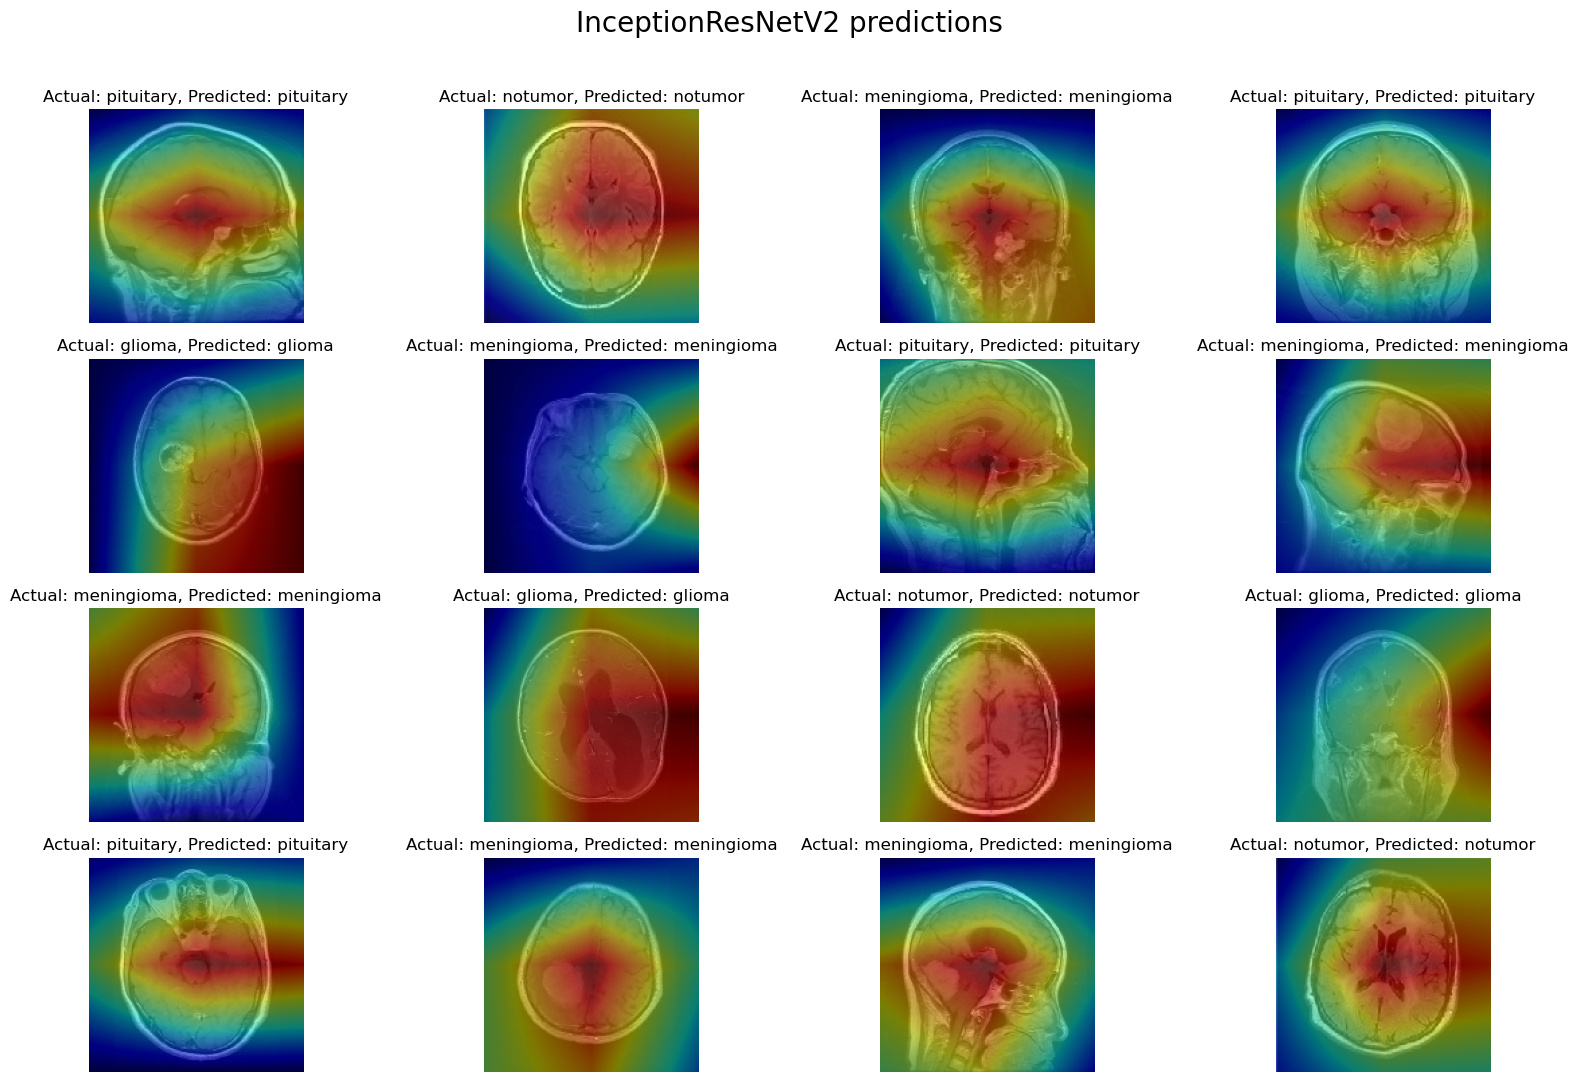

In [5]:

best_model = load_model('models/InceptionResNetV2_model.h5')

gradcam = Gradcam(best_model, model_modifier=ReplaceToLinear(), clone=True)  

plt.figure(figsize=(17, 11))
plt.suptitle("InceptionResNetV2 predictions", fontsize=20)


for i, (image, actual_class, predicted_class) in enumerate(zip(images_batch, actual_classes, InceptionResNetV2_predictions)):

    score = CategoricalScore([predicted_class])

    heatmap = gradcam(score, np.array([image]))

    plt.subplot(columns, rows, i + 1)
    
    plt.imshow(image, alpha=1.0)
    
    plt.imshow(heatmap[0], cmap='jet', alpha=0.5)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig('Graphs/InceptionResNetV2/Gradcam.png', format='png')
plt.show()


del gradcam , best_model

<h3> InceptionV3 </h3>

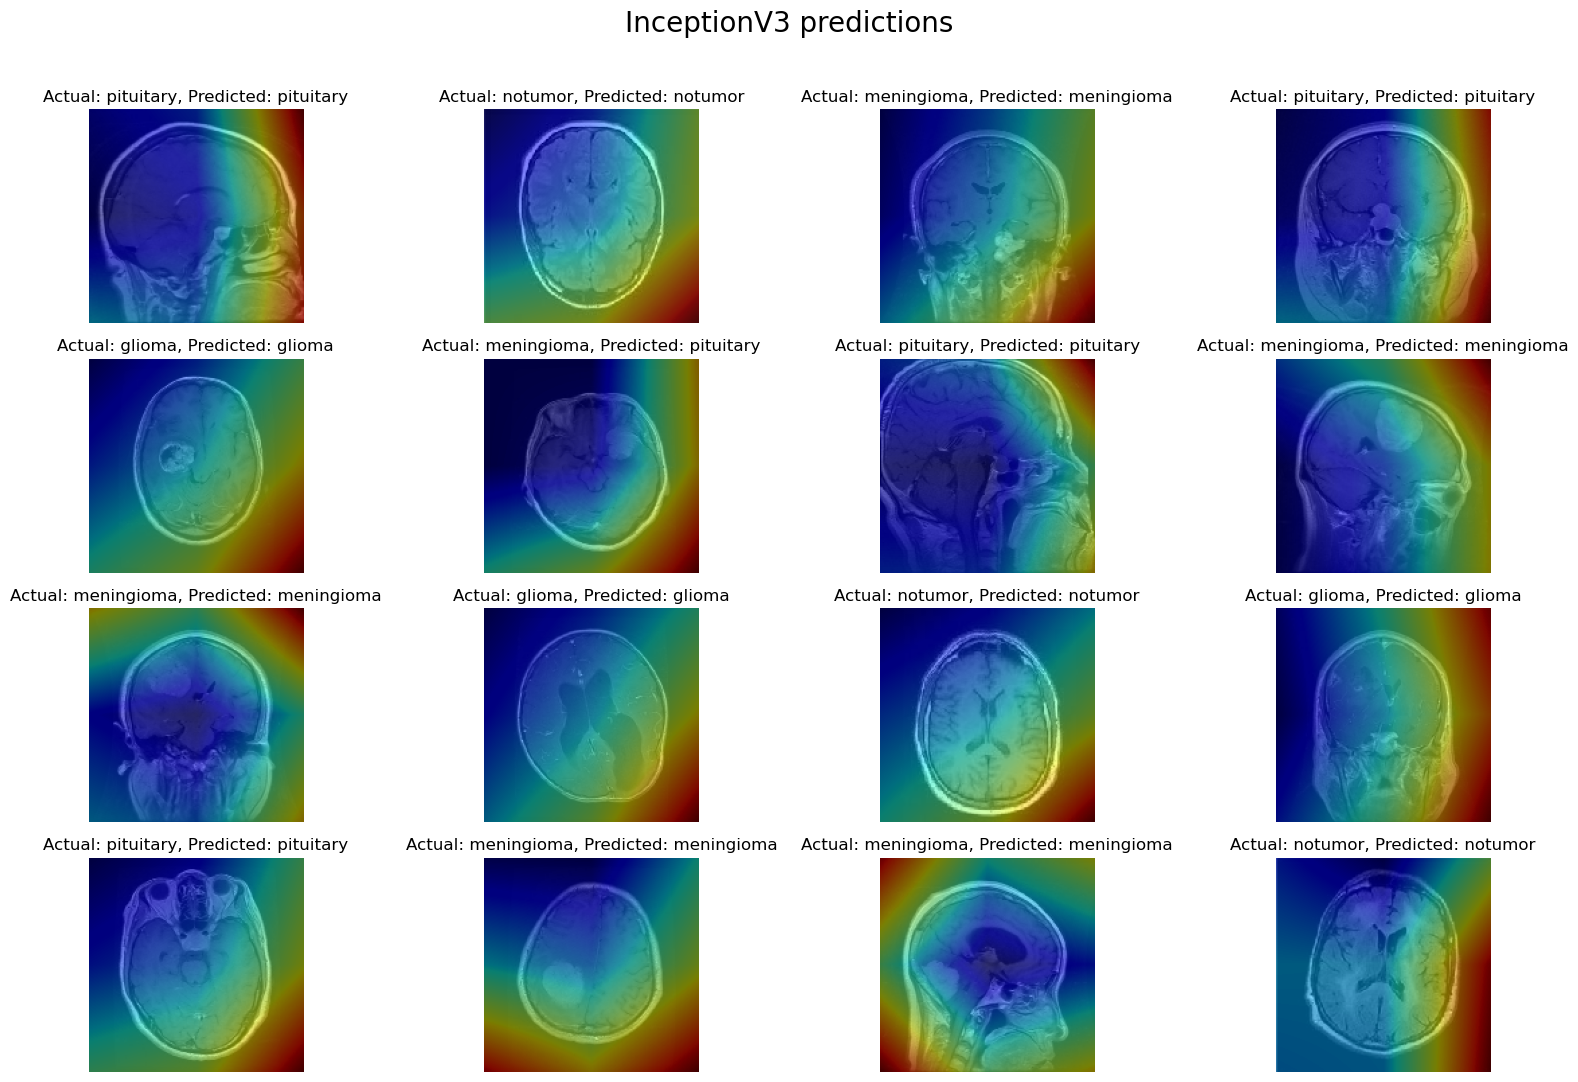

84599

In [6]:
best_InceptionV3_model = load_model('models/InceptionV3_model.h5')

gradcam = Gradcam(best_InceptionV3_model, model_modifier=ReplaceToLinear(), clone=True)

plt.figure(figsize=(17, 11))
plt.suptitle("InceptionV3 predictions", fontsize=20)

for i, (image, actual_class, predicted_class) in enumerate(zip(images_batch, actual_classes, InceptionV3_predictions)):
    score = CategoricalScore([predicted_class])

    heatmap = gradcam(score, np.array([image]),)

    plt.subplot(columns, rows, i + 1)
    
    plt.imshow(image, alpha=1.0)
    
    plt.imshow(heatmap[0], cmap='jet', alpha=0.5)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('Graphs/InceptionV3/Gradcam.png', format='png')
plt.show()


del gradcam , best_InceptionV3_model
gc.collect()

<h3> ResNet50 </h3>

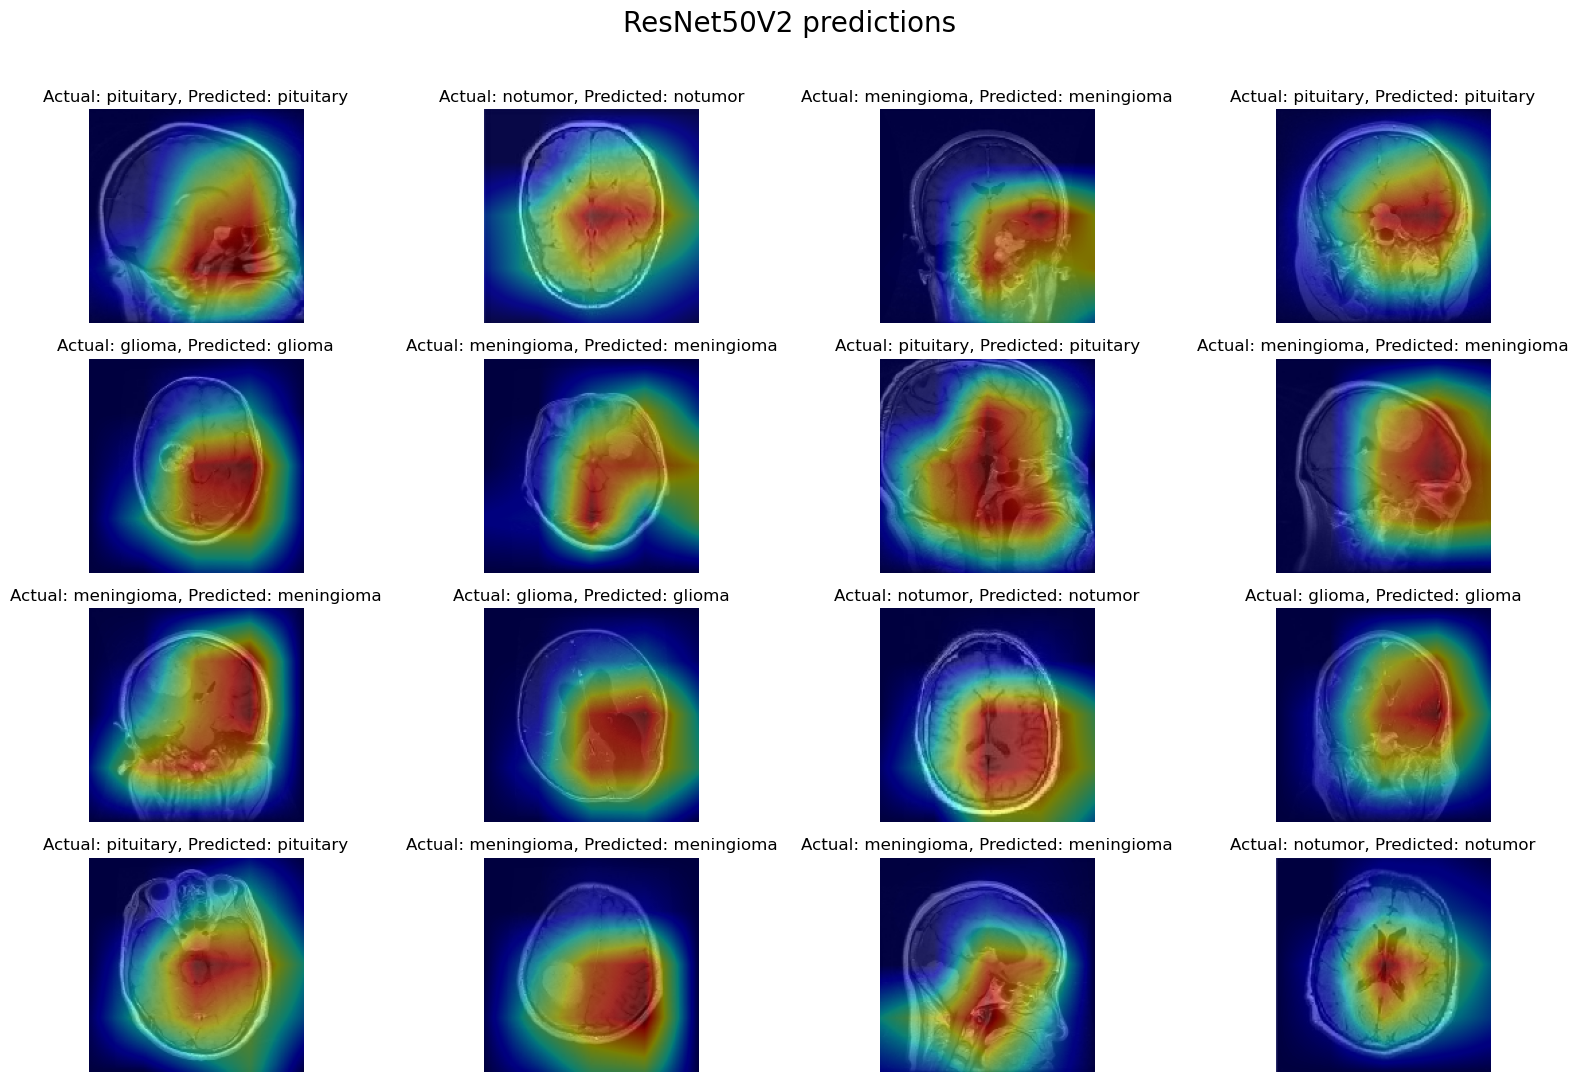

53194

In [7]:
best_ResNet50V2_model = load_model('models/ResNet50V2_model.h5')

gradcam = Gradcam(best_ResNet50V2_model, model_modifier=ReplaceToLinear(), clone=False)

plt.figure(figsize=(17, 11))
plt.suptitle("ResNet50V2 predictions", fontsize=20)

for i, (image, actual_class, predicted_class) in enumerate(zip(images_batch, actual_classes, ResNet50V2_predictions)):
    score = CategoricalScore([predicted_class])

    heatmap = gradcam(score, np.array([image]),)

    plt.subplot(columns, rows, i + 1)
    
    plt.imshow(image, alpha=1.0)
    
    plt.imshow(heatmap[0], cmap='jet', alpha=0.5)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")


plt.savefig('Graphs/ResNet50V2/Gradcam.png', format='png')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


del gradcam , best_ResNet50V2_model
gc.collect()

<h1> GradCamPlusPlus </h1>

<h3> InceptionResNetV2

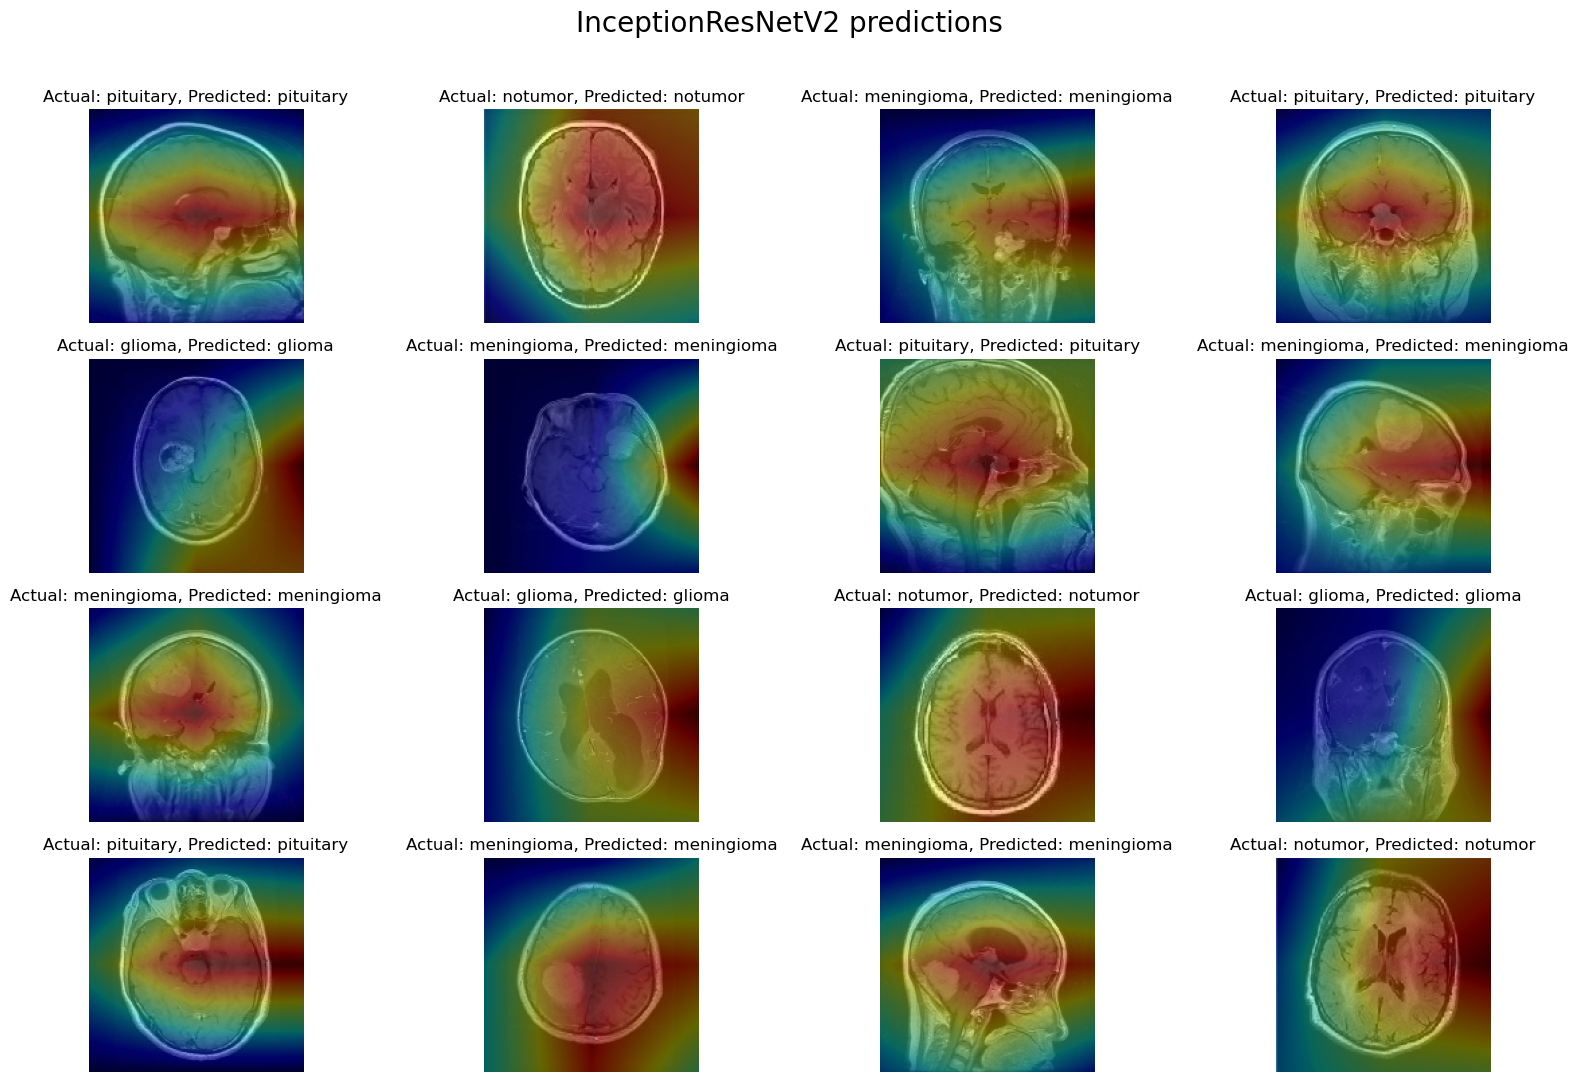

95870

In [8]:
best_model = load_model('models/InceptionResNetV2_model.h5')

InceptionResNetV2_gradcam_plus_plus = GradcamPlusPlus(best_model, model_modifier=ReplaceToLinear(), clone=False)

plt.figure(figsize=(17, 11))
plt.suptitle("InceptionResNetV2 predictions", fontsize=20)


for i, (image, actual_class, predicted_class) in enumerate(zip(images_batch, actual_classes, InceptionResNetV2_predictions)):

    score = CategoricalScore([predicted_class])

    heatmap = InceptionResNetV2_gradcam_plus_plus(score, np.array([image]),)

    plt.subplot(columns, rows, i + 1)
    
    plt.imshow(image, alpha=1.0)
    
    plt.imshow(heatmap[0], cmap='jet', alpha=0.4)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig('Graphs/InceptionResNetV2/GradcamPlusPlus.png', format='png')
plt.show()


del InceptionResNetV2_gradcam_plus_plus , best_model
gc.collect()

<h3> InceptionV3

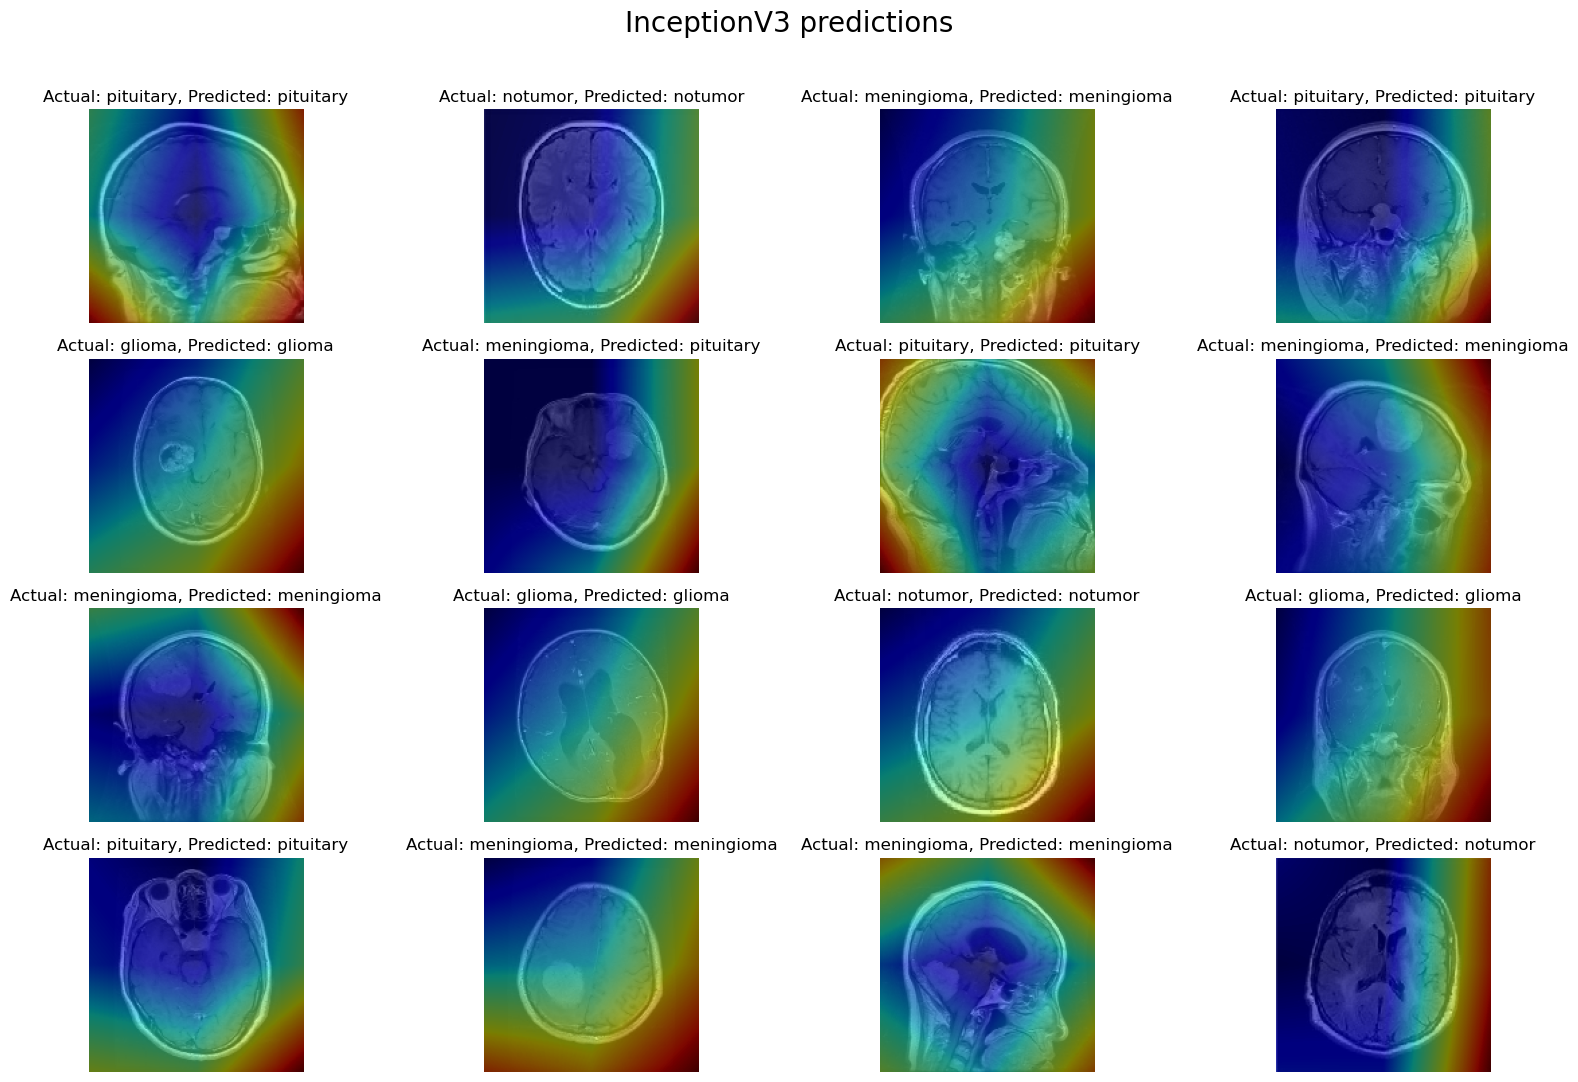

62510

In [9]:
best_InceptionV3_model = load_model('models/InceptionV3_model.h5')

InceptionV3_gradcam_plus_plus = GradcamPlusPlus(best_InceptionV3_model, model_modifier=ReplaceToLinear(), clone=False)

plt.figure(figsize=(17, 11))
plt.suptitle("InceptionV3 predictions", fontsize=20)

for i, (image, actual_class, predicted_class) in enumerate(zip(images_batch, actual_classes, InceptionV3_predictions)):
    score = CategoricalScore([predicted_class])

    heatmap = InceptionV3_gradcam_plus_plus(score, np.array([image]),)

    plt.subplot(columns, rows, i + 1)
    
    plt.imshow(image, alpha=1.0)
    
    plt.imshow(heatmap[0], cmap='jet', alpha=0.5)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig('Graphs/InceptionV3/GradcamPlusPlus.png', format='png')
plt.show()


del InceptionV3_gradcam_plus_plus , best_InceptionV3_model
gc.collect()

<h3> ResNet50V2

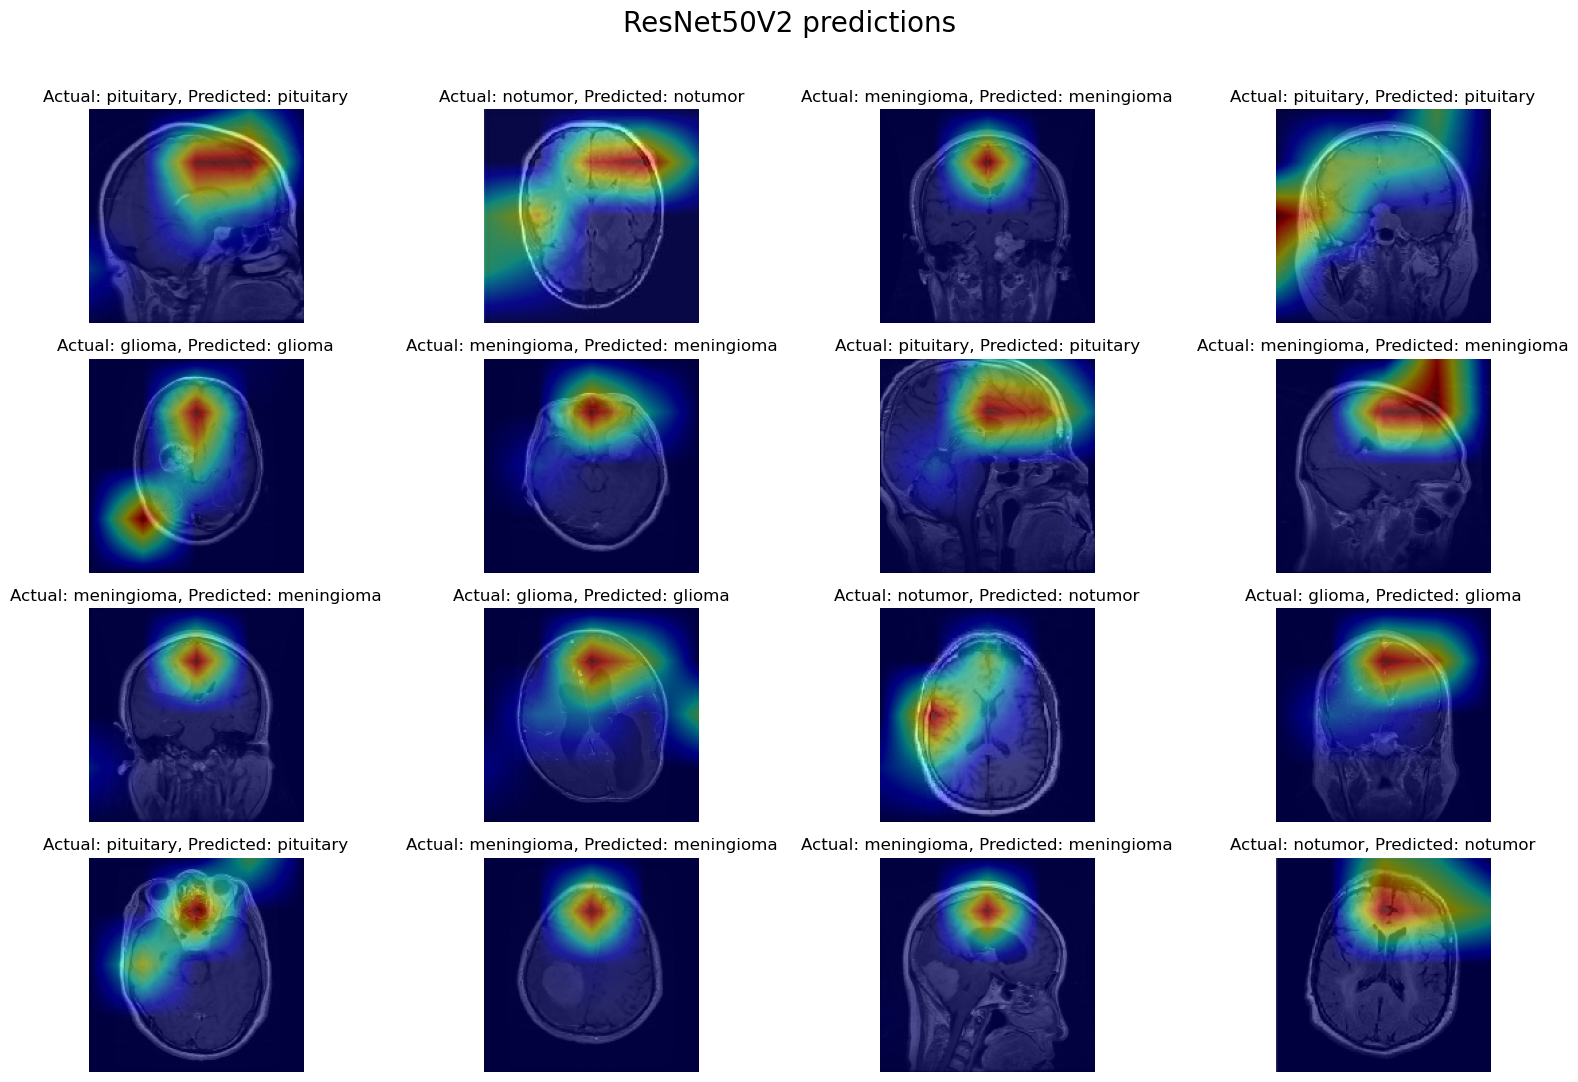

53180

In [10]:

best_ResNet50V2_model = load_model('models/ResNet50V2_model.h5')

ResNet50V2_gradcam_plus_plus = GradcamPlusPlus(best_ResNet50V2_model, model_modifier=ReplaceToLinear(), clone=False)

plt.figure(figsize=(17, 11))
plt.suptitle("ResNet50V2 predictions", fontsize=20)

for i, (image, actual_class, predicted_class) in enumerate(zip(images_batch, actual_classes, ResNet50V2_predictions)):
    score = CategoricalScore([predicted_class])

    heatmap = ResNet50V2_gradcam_plus_plus(score, np.array([image]),)

    plt.subplot(columns, rows, i + 1)
    
    plt.imshow(image, alpha=1.0)
    
    plt.imshow(heatmap[0], cmap='jet', alpha=0.5)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig('Graphs/ResNet50V2/GradcamPlusPlus.png', format='png')
plt.show()


del ResNet50V2_gradcam_plus_plus , best_ResNet50V2_model
gc.collect()

<h1>Lime

<h3> InceptionResNetV2

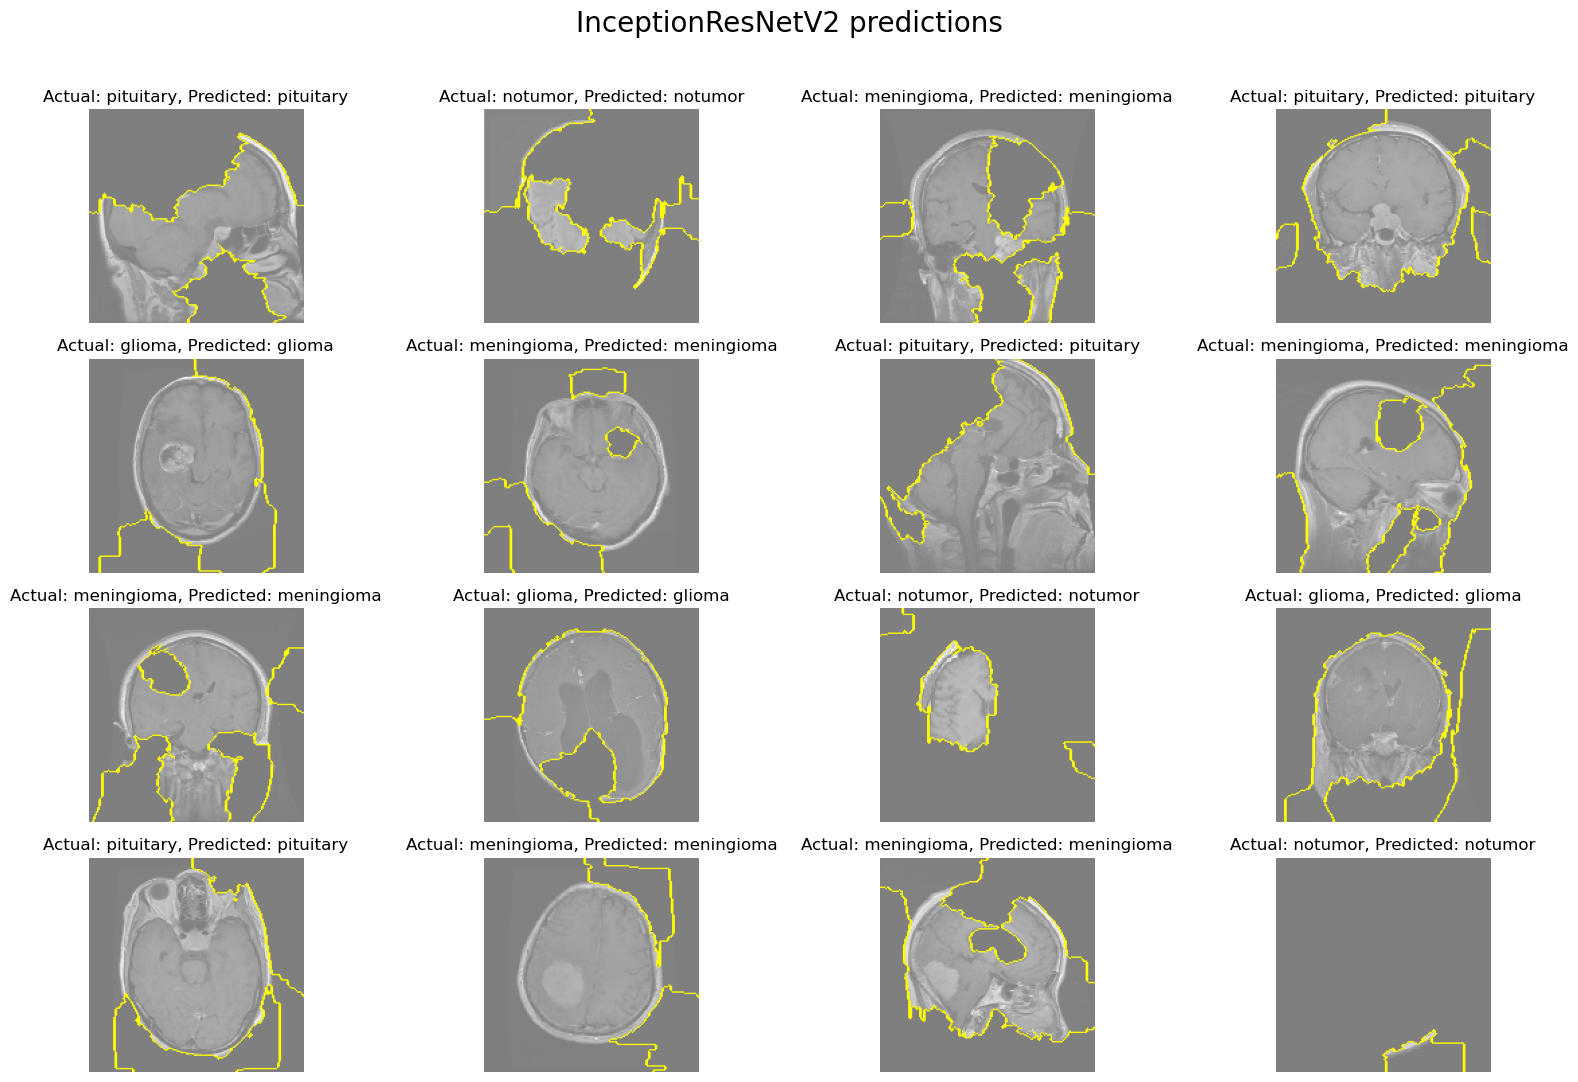

155325

In [11]:
gc.collect()
import io
import sys

from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

original_stdout = sys.stdout
original_stderr = sys.stderr
sys.stdout = sys.stderr = io.StringIO()

best_model = load_model('models/InceptionResNetV2_model.h5')

plt.figure(figsize=(17, 11))
plt.suptitle("InceptionResNetV2 predictions", fontsize=20)

for i, (image, actual_class, predicted_class) in enumerate(zip(images_batch, actual_classes, InceptionResNetV2_predictions)):
    explanation = explainer.explain_instance(image, best_model.predict, top_labels=5, hide_color=True, num_samples=1000)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)

    plt.subplot(columns, rows, i + 1)
    
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), alpha=1)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")
    
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig('Graphs/InceptionResNetV2/Lime.png', format='png')
plt.show()


del best_model
gc.collect()


<h3> Lime InceptionV3

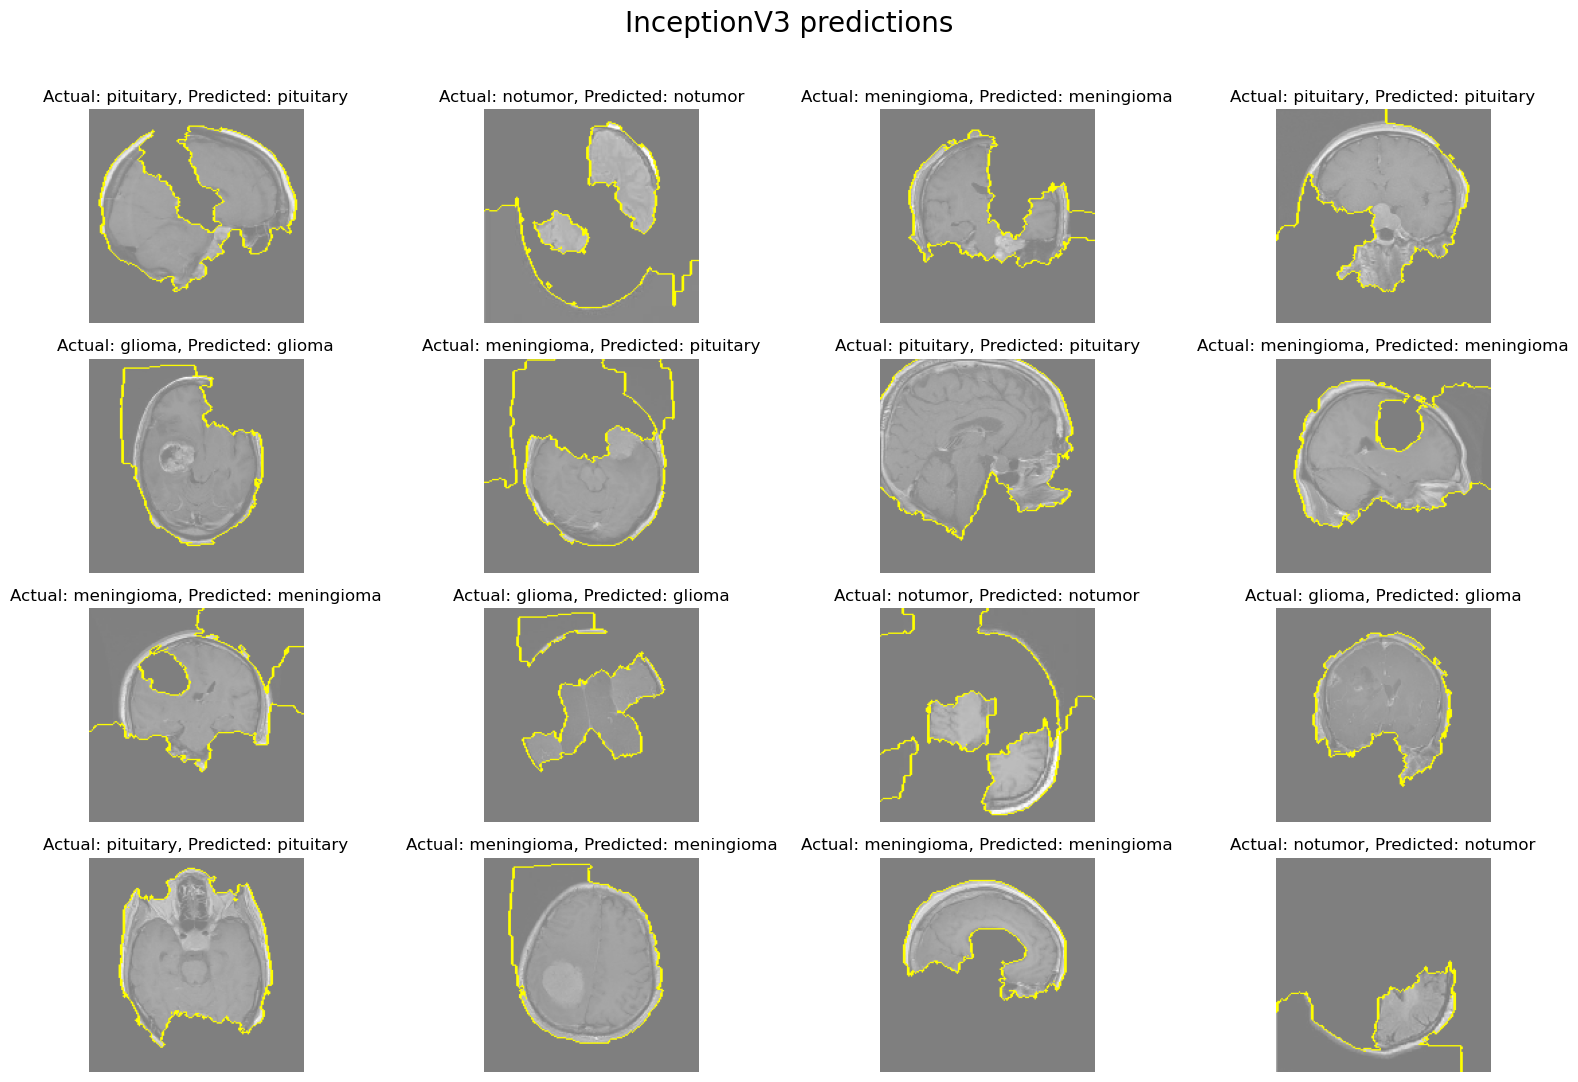

120120

In [12]:
gc.collect()

best_InceptionV3_model = load_model('models/InceptionV3_model.h5')

plt.figure(figsize=(17, 11))
plt.suptitle("InceptionV3 predictions", fontsize=20)

for i, (image, actual_class, predicted_class) in enumerate(zip(images_batch, actual_classes, InceptionV3_predictions)):
    explanation = explainer.explain_instance(image, best_InceptionV3_model.predict, top_labels=5, hide_color=True, num_samples=1000)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

    plt.subplot(columns, rows, i + 1)
    
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), alpha=1)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig('Graphs/InceptionV3/Lime.png', format='png')
plt.show()


del best_InceptionV3_model
gc.collect()

<h3> ResNet50V2

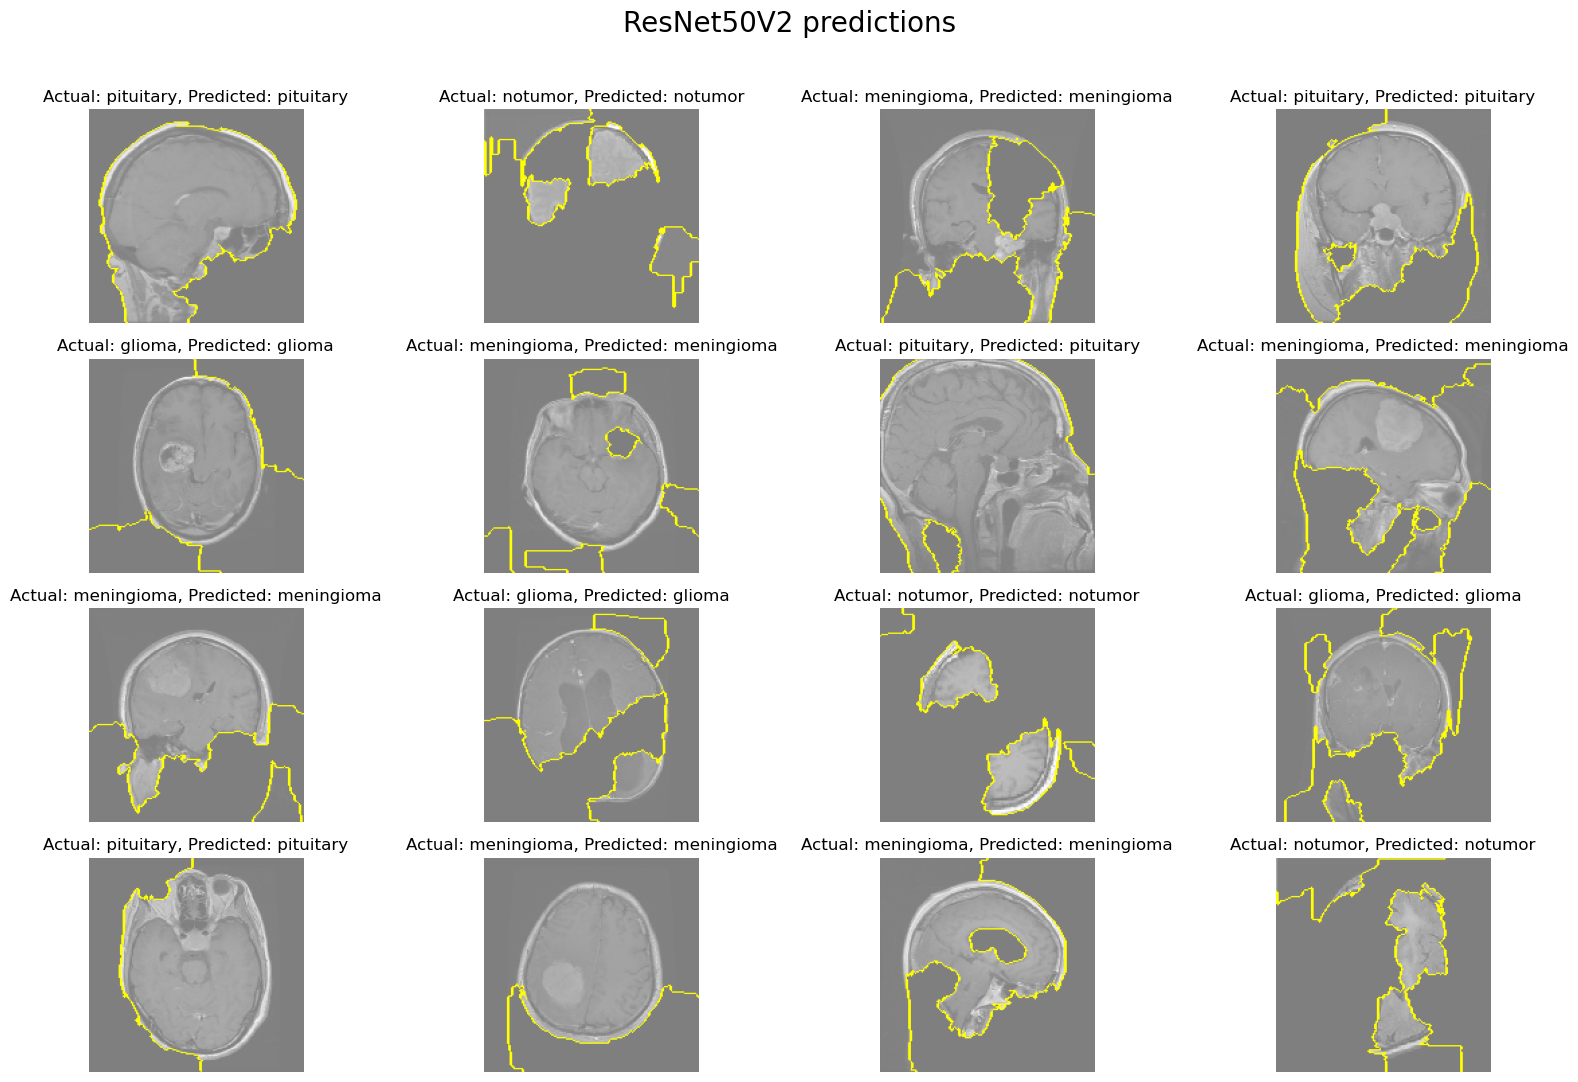

98467

In [13]:
gc.collect()

best_ResNet50V2_model = load_model('models/ResNet50V2_model.h5')

plt.figure(figsize=(17, 11))
plt.suptitle("ResNet50V2 predictions", fontsize=20)

for i, (image, actual_class, predicted_class) in enumerate(zip(images_batch, actual_classes, ResNet50V2_predictions)):
    explanation = explainer.explain_instance(image, best_ResNet50V2_model.predict, top_labels=4, hide_color=True, num_samples=1000)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)

    plt.subplot(columns, rows, i + 1)
    
    #plt.imshow(image, alpha=1.0)
    
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), alpha=1)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig('Graphs/ResNet50V2/Lime.png', format='png')
plt.show()


sys.stdout = original_stdout

del best_ResNet50V2_model
gc.collect()